<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 2*

# Sprint Challenge - Neural Network Foundations

Table of Problems

1. [Defining Neural Networks](#Q1)
2. [Simple Perceptron](#Q2)
    - Perceptron
    - Multilayer Perceptron
    - Analyze and Compare
4. [Keras MMP](#Q3)

In [0]:
# imports
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

<a id="Q1"></a>
## 1. Defining Neural Networks 

Write *your own* definitions for the following terms:

- **Neuron:**a neuron is a node or singal point in a Neural Network that recieves inputs and passes a signal to other nodes in the network

- **Input Layer:** The input layer is the layer that recieves input from our dataset. This is the only visible layer that is exposed to our data or that interacts directly with our data. It's standard to have an input layer for each feature in our dataset

- **Hidden Layer:** Hidden layers are nodes that are only accessed via the input layer. These nodes perform various functions that we cannot see. The amount of hidden nodes in a network can vary depening on the type of network being used

- **Output Layer:**the output layer is the final layer that provides the ouptu of a vector of values. The Output layer is modified by an activation function which transforms the Network output into a format that makes sense for the context of the problem (i.e. accuracy, mae)

- **Activation Function:** an activation function determines whether a neuron should be activated typically by calculating the weighted sum and adding bias. If a node/neuron's input is not relevant to the model prediction, the activation funciton will not use that node/neuron. 

Explain how back propagation works as if you were explaining it to a five year-old. Use your own words, but feel free to reference external materials for this question. 

#### **Backpropagation ELI5** 
Alright Jimmy, listen up. Backpropagation is very similar to a game of telephone(or whatever you call that game these days). 
When you play a game of telephone, it's hard to know who's lying and who's telling the truth. Image you played a game you could choose to get the "telephone word" from Sarah or Jack. Now the first time you'd probably just pick Jack becuase he's your friend. 

But what if you found out that Jack lied to you about what the Telephone word was and that Sarah actually told the truth. Well the next time you played that game you'd probably ask Sarah instead of Jack becuase her information is more reliable/right. 

Now imagine if you played this game with 100 of your friends(all of kindergarden)? That's a lot of people!! So Backpropagation allows you to ask all your friends what the Telephone word is and then you can play the game again and pick your friends that provided the best infromation/answer. 

Now, your chances of winning the game of Telephone are much higher becuase your listening to people who are better at telling you the correct word. 

Remember our Simple Perceptron Class from Monday. In a simple prediction describe the process of making a prediction. How do you go from inputs to predicted output.

**Simple Perceptron**

A perceptron acts as a single node in a Nueral Network. At the most simplistic level, a perceptron takes an input and returns a given output(signal). More specifically, the perceptron takes the input values and multiplies each input value by a weight. Those weights are then summed and that summed product is passed through an activation function. If the node is determined to be valuable/provide a good signal then the nueron/node will fire and return the final output. 

<a id="Q2"></a>
## 2. Simple Perceptron

In this question, you will build two neural networks using Tensorflow Keras. After you build these two models, compare the results of the model.

In [0]:
"""
Our Dataset
"""
import numpy as np

xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)

"Use this X & y in the following 2 models"
X = rng.randn(300, 2)
y = np.array(np.logical_xor(X[:, 0] > 0, X[:, 1] > 0), 
             dtype=int)

In [16]:
print(X.shape)
print(y.shape)

(300, 2)
(300,)


### Simple Perceptron
Construct a simple perceptron using Keras. You model should have 1 dense layer with a single neuron and a sigmoid activation function. Your model should be called `model1` and make sure to save the results of your fit statement to a variable called `h1`. 

In [56]:
model1 = Sequential([
        Dense(1, input_dim=2, activation='sigmoid'),
        Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

h1 = model1.fit(X, y, epochs=25)

Epoch 1/25
10/10 [==============================] - 0s 1ms/step - loss: 0.2506 - accuracy: 0.5267
Epoch 2/25
10/10 [==============================] - 0s 1ms/step - loss: 0.2503 - accuracy: 0.5267
Epoch 3/25
10/10 [==============================] - 0s 1ms/step - loss: 0.2501 - accuracy: 0.5267
Epoch 4/25
10/10 [==============================] - 0s 1ms/step - loss: 0.2498 - accuracy: 0.5267
Epoch 5/25
10/10 [==============================] - 0s 1ms/step - loss: 0.2496 - accuracy: 0.5267
Epoch 6/25
10/10 [==============================] - 0s 1ms/step - loss: 0.2494 - accuracy: 0.5233
Epoch 7/25
10/10 [==============================] - 0s 1ms/step - loss: 0.2493 - accuracy: 0.5200
Epoch 8/25
10/10 [==============================] - 0s 1ms/step - loss: 0.2492 - accuracy: 0.5233
Epoch 9/25
10/10 [==============================] - 0s 1ms/step - loss: 0.2490 - accuracy: 0.5233
Epoch 10/25
10/10 [==============================] - 0s 1ms/step - loss: 0.2489 - accuracy: 0.5200
Epoch 11/25
10/10 [

## Model 1 Accuracy = 58.33%

### Multi-Layer Perceptron
Now construct a multi-layer perceptron using. Here are some architecture suggestions: 
- 2 Hidden Layers
- 5-32 Neurons in the Hidden Layers
- Your pick of activation function and optimizer
- Incorporate the Callback function below into your model

Your model should be called `model2` and make sure to save the results of your fit statement to a variable called `h2`. 

In [0]:
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > .99999):   
            self.model.stop_training = True

In [54]:
# create model and add layers
model2 = Sequential([
        Flatten(),
        Dense(10, input_dim=2, activation ='relu'),
        Dense(20, activation='linear'),
        Dense(1, activation='linear'),
])

# compile and fit
model2.compile(optimizer='adam', loss='mean_squared_error', metrics =['accuracy'])
h2 = model2.fit(X, y, 
                epochs=25,
                callbacks=[myCallback()]
                )

Epoch 1/25
10/10 [==============================] - 0s 1ms/step - loss: 0.4135 - accuracy: 0.5767
Epoch 2/25
10/10 [==============================] - 0s 1ms/step - loss: 0.2840 - accuracy: 0.6233
Epoch 3/25
10/10 [==============================] - 0s 1ms/step - loss: 0.2149 - accuracy: 0.6500
Epoch 4/25
10/10 [==============================] - 0s 1ms/step - loss: 0.1768 - accuracy: 0.7500
Epoch 5/25
10/10 [==============================] - 0s 1ms/step - loss: 0.1510 - accuracy: 0.8067
Epoch 6/25
10/10 [==============================] - 0s 1ms/step - loss: 0.1349 - accuracy: 0.8200
Epoch 7/25
10/10 [==============================] - 0s 1ms/step - loss: 0.1254 - accuracy: 0.8567
Epoch 8/25
10/10 [==============================] - 0s 1ms/step - loss: 0.1181 - accuracy: 0.8600
Epoch 9/25
10/10 [==============================] - 0s 1ms/step - loss: 0.1119 - accuracy: 0.8800
Epoch 10/25
10/10 [==============================] - 0s 2ms/step - loss: 0.1071 - accuracy: 0.8900
Epoch 11/25
10/10 [

### Analyze and Compare

**Before you Start**: You will need to install an additional library for this next segment. Install the package `mlxtend` into the environment you are using for the sprint challenge.


The cells below generate decision boundary plots of your models (`model1` & `model2`). Review the plots.

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


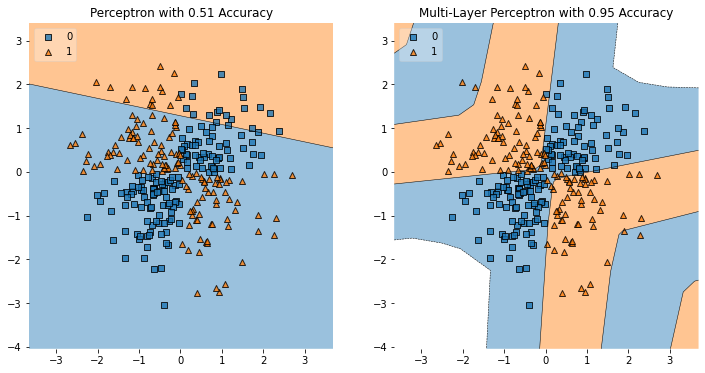

In [57]:
# Do Not change anything in this cell

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

h = .02  # step size in the mesh

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - .2, X[:, 0].max() + .2
y_min, y_max = X[:, 1].min() - .2, X[:, 1].max() + .2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

fig = plt.figure(figsize=(12,6))


for clf, hist, name, grd in zip([model1,model2], [h1, h2],['Perceptron', 'Multi-Layer Perceptron'],[1,2]):

    ax = plt.subplot(1,2, grd)
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    title = f"{name} with {hist.history['accuracy'][-1]:,.2f} Accuracy"
    plt.title(title)

plt.show()

Why does the Perceptron (`model1`) only achieve ~70% accuracy? What is the architectural property of the Multi-Layer Perceptron that allows it more accurately learn the relationship between X and y? 

Why might this property be useful in more complex data such as images?

### **Single vs Mulit-layer Perceptron**
Since our multi-layer perceptron contains more hidden layers it can learn functions that are non-linear which helps reduce error and increase model accuracy. Since the single perceptron is only looking for a linear relationship, it is limited in the conclusions/predictions that the model can make. 

In each nueral network, nodes provide a signal and since there are more nodes in the Multi-layer perceptron, they can be definition provide more signals, some of which will be more helpful for evaluating a certian problem. 

Images are comprosed of various hex colors which are all various shades of Red, Green, or Blue making tens of millions of combinations. A standard image could have a complex array of colors which then make up people, places, or objects from those colors. This accounts for a vast assortment of possibilities. Therefore, for a computer to to dycipher images into an actual actionable solution (e.g. this is an apple) requires non-linear prediction capabilities. 

Without the ability to evaluate strong nonlinearities, neural networks functionality would be very limited. 

## 3. Keras MMP <a id="Q3"></a>

Implement a Multilayer Perceptron architecture of your choosing using the Keras library. Train your model and report its baseline accuracy. Then hyperparameter tune at least two parameters and report your model's accuracy.
Use the Heart Disease Dataset (binary classification)
Use an appropriate loss function for a binary classification task
Use an appropriate activation function on the final layer of your network.
Train your model using verbose output for ease of grading.
Use GridSearchCV or RandomSearchCV to hyperparameter tune your model. (for at least two hyperparameters)
When hyperparameter tuning, show you work by adding code cells for each new experiment.
Report the accuracy for each combination of hyperparameters as you test them so that we can easily see which resulted in the highest accuracy.
You must hyperparameter tune at least 3 parameters in order to get a 3 on this section.

In [78]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/heart.csv')
df = df.sample(frac=1)
print(df.shape)
df.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
13,64,1,3,110,211,0,0,144,1,1.8,1,0,2,1
128,52,0,2,136,196,0,0,169,0,0.1,1,0,2,1
22,42,1,0,140,226,0,1,178,0,0.0,2,0,2,1
287,57,1,1,154,232,0,0,164,0,0.0,2,1,2,0
99,53,1,2,130,246,1,0,173,0,0.0,2,3,2,1


In [79]:
X = np.array(df.drop(columns=['target']))
X.shape

(303, 13)

In [80]:
y = np.array(df['target'])
y.shape

(303,)

In [81]:
# baseline model 

# create model
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=13))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
model.fit(X,y, epochs=10, batch_size=20)

Epoch 1/10
16/16 [==============================] - 0s 1ms/step - loss: 8.3997 - accuracy: 0.4554
Epoch 2/10
16/16 [==============================] - 0s 1ms/step - loss: 8.3997 - accuracy: 0.4554
Epoch 3/10
16/16 [==============================] - 0s 1ms/step - loss: 8.3997 - accuracy: 0.4554
Epoch 4/10
16/16 [==============================] - 0s 1ms/step - loss: 8.3997 - accuracy: 0.4554
Epoch 5/10
16/16 [==============================] - 0s 1ms/step - loss: 8.3997 - accuracy: 0.4554
Epoch 6/10
16/16 [==============================] - 0s 1ms/step - loss: 8.3997 - accuracy: 0.4554
Epoch 7/10
16/16 [==============================] - 0s 1ms/step - loss: 8.3997 - accuracy: 0.4554
Epoch 8/10
16/16 [==============================] - 0s 1ms/step - loss: 8.3997 - accuracy: 0.4554
Epoch 9/10
16/16 [==============================] - 0s 1ms/step - loss: 8.3997 - accuracy: 0.4554
Epoch 10/10
16/16 [==============================] - 0s 1ms/step - loss: 8.3997 - accuracy: 0.4554


Baseline Accuracy = 45.87%

In [0]:
# from tensorflow.keras.optimizers import Adam
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

In [0]:
# hyperparameter tuning using GridSearchCV
epochs = [5, 10]
batch_size = [5, 10, 100]
optimizers = ['rmsprop', 'adam']

# Function to create model and required for KerasClassifier
def create_model(optimizer = 'adam'):
    model = Sequential()
    model.add(Dense(32, input_dim=13, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search hyperparameters
params = dict(optimizer=optimizers, epochs=epochs, batch_size=batch_size)

# Create Grid Search
grid = GridSearchCV(estimator=model, scoring='accuracy', param_grid=params)
grid_result = grid.fit(X, y)

In [94]:
# results
print("Accuracy:", grid_result.best_score_, "best params", grid_result.best_params_)

Accuracy: 0.7125136612021856 best params {'batch_size': 5, 'epochs': 10, 'optimizer': 'adam'}
